In [ ]:
#######################################################################################
!pip install torch torchvision torchaudio --quiet
!pip install numpy pandas scikit-learn tqdm matplotlib --quiet
########################################################################################

!git clone https://github.com/HelenGuohx/logbert.git
%cd logbert


!ls


import sys
sys.path.append("/content/logbert")


import torch
from bert_pytorch.model.log_model import BERTLog
from bert_pytorch.model.bert import BERT
import torch.nn as nn


vocab_size = 10000
max_len = 128
hidden = 768
n_layers = 12
attn_heads = 12
dropout = 0.3
is_logkey = True
is_time = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


bert_model = BERT(
    vocab_size=vocab_size,
    max_len=max_len,
    hidden=hidden,
    n_layers=n_layers,
    attn_heads=attn_heads,
    dropout=dropout,
    is_logkey=is_logkey,
    is_time=is_time
).to(device)


class BERTLog(nn.Module):
    def __init__(self, bert, vocab_size):
        super().__init__()
        self.bert = bert
        self.logkey_predictor = nn.Linear(bert.hidden, vocab_size)
        if self.bert.is_time:
            self.time_predictor = nn.Linear(bert.hidden, bert.max_len) # Example output size, adjust as needed
        else:
            self.time_predictor = None

        # Add classification heads if they exist in your original model structure
        if hasattr(bert, 'cls_head'):
             self.cls_head = bert.cls_head
        if hasattr(bert, 'cls_fnn'):
            self.cls_fnn = bert.cls_fnn


    def forward(self, x, time_info=None):
        mask = (x > 0).unsqueeze(1).repeat(1, x.size(1), 1).unsqueeze(1)
        encoded_layers = self.bert(x, time_info, mask) # Original forward pass

        logkey_output = self.logkey_predictor(encoded_layers)
        time_output = None
        if self.time_predictor:
            time_output = self.time_predictor(encoded_layers)

        # Include classification head outputs if available
        cls_output = None
        if hasattr(self, 'cls_head'):
            cls_output = self.cls_head(encoded_layers[:, 0]) # Assuming CLS token at index 0

        cls_fnn_output = None
        if hasattr(self, 'cls_fnn'):
            cls_fnn_output = self.cls_fnn(encoded_layers[:, 0]) # Assuming CLS token at index 0


        return {'logkey_output': logkey_output,
                'time_output': time_output,
                'cls_output': cls_output,
                'cls_fnn_output': cls_fnn_output}

    def forward_from_embedding(self, x_emb, time_info=None):

        dummy_x = torch.ones(x_emb.shape[0], x_emb.shape[1], dtype=torch.long, device=x_emb.device) # Dummy input for mask
        mask = (dummy_x > 0).unsqueeze(1).repeat(1, dummy_x.size(1), 1).unsqueeze(1)



        pass # Reverting this method

Cloning into 'logbert'...
remote: Enumerating objects: 133, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 133 (delta 12), reused 11 (delta 11), pack-reused 78 (from 1)
Receiving objects: 100% (133/133), 211.46 KiB | 7.83 MiB/s, done.
Resolving deltas: 100% (22/22), done.
/content/logbert
bert_pytorch  environment  img	    logdeep   logparser  README.md  TBird
BGL	      HDFS	   LICENSE  loglizer  Pipfile	 scripts
Using device: cuda


In [ ]:
import json
import pandas as pd
import re

test_path = "/content/new.json"  # or "/mnt/data/new.json" locally

def load_any_json_to_df(test_path: str) -> pd.DataFrame:
    with open(test_path, "r", encoding="utf-8") as f:
        raw = f.read().strip()

    # Quick normalize: sometimes objects are concatenated like ...}{...
    raw = raw.replace("}\n{", "}\n{")   # keep
    raw = raw.replace("}{", "}\n{")     # fix missing newline

    # Case A: JSON array: [ {...}, {...} ]
    if raw.lstrip().startswith("["):
        data = json.loads(raw)
        return pd.json_normalize(data)

    # Case B: JSON Lines: one {...} per line (may also have commas at line ends)
    lines = [ln.strip().rstrip(",") for ln in raw.splitlines() if ln.strip()]

    records = []
    for ln in lines:
        # skip junk lines if any
        if not ln.startswith("{"):
            continue
        records.append(json.loads(ln))

    if not records:
        raise ValueError("No JSON objects found. The file may be malformed.")

    return pd.json_normalize(records)

test_df = load_any_json_to_df(test_path)
print(test_df.shape)
print(test_df.head(2))


(181, 8)
   sequence_id                                               logs  \
0           10  [test 24.35 4386.77 494.59 pass 0 0, test 52.7...   
1           11  [test 87.0 4801.2 147.73 fail 1 3, build 42.05...   

                                            features numeric_sequence labels  \
0  [{'component': 'test', 'cpu_usage': '24.35', '...              NaN    NaN   
1  [{'component': 'test', 'cpu_usage': '87.0', 'm...              NaN    NaN   

  label  seq_len seq_id  
0   NaN      NaN    NaN  
1   NaN      NaN    NaN  


In [ ]:
# Keep sequences as a list (no need to convert to NumPy array)
test_samples = test_df['logs'].tolist()[:200]

# Check length of first 5 sequences
for i, seq in enumerate(test_samples[:5]):
    print(f"Sample {i} length: {len(seq)}")

Sample 0 length: 16
Sample 1 length: 16
Sample 2 length: 16
Sample 3 length: 16
Sample 4 length: 16


In [ ]:
import torch
import numpy as np

# Assuming you have your trained LogBERT model
# model = ... (your trained LogBERT)
# tokenizer = ... (if needed for mapping)

def logbert_predict(sequences):
    """
    sequences: list of numeric sequences (list of ints)
    returns: np.array of prediction probabilities
    """
    model.eval()
    outputs = []

    with torch.no_grad():
        for seq in sequences:
            # Convert to tensor and add batch dimension
            input_tensor = torch.tensor([seq], dtype=torch.long)  # shape: [1, seq_len]

            # Get model prediction (adjust depending on your model's output)
            logits = model(input_tensor)  # shape: [1, num_classes]
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            outputs.append(probs[0])

    return np.array(outputs)


In [ ]:
import json
import numpy as np

# 1️⃣ Load tokenizer
with open('/content/tokenizer.json', 'r') as f:
    tokenizer = json.load(f)

# Reverse the tokenizer: id -> token
id_to_token = {v: k for k, v in tokenizer.items()}

# 2️⃣ Define token meanings (from your earlier dictionary)
token_meanings = {
    "<PAD>": "padding",
    "M": "commit",
    "i": "input",
    "x": "execution",
    "e": "entry",
    "d": "data",
    " ": "space",
    "s": "session",
    "q": "query",
    "u": "user",
    "n": "null",
    "c": "command",
    "\u2192": "transition",
    "2": "code_2",
    "o": "output",
    "r": "request",
    "m": "malware",
    "a": "access",
    "l": "login",
    ",": "delimiter",
    "1": "code_1",
    "g": "gateway",
    "/": "slash",
    ";": "semicolon",
    "C": "Chrome",
    ":": "colon",
    "P": "protocol",
    "t": "token",
    "v": "value",
    "E": "entry_event",
    "A": "access_event",
    "y": "yield",
    "Y": "yield2",
    "5": "code_5",
    "b": "buffer",
    "f": "flag",
    "N": "null_event",
    "4": "code_4",
    "3": "code_3",
    "S": "TCP_Session",
    "T": "TCP",
    "p": "packet",
    "w": "workflow",
    "I": "ICMP",
    "h": "heartbeat"
}

# 3️⃣ Load tokenized inputs
data = np.load('/content/tokenized_inputs.npz')
tokenized_inputs = data['tokenized_inputs']

# 4️⃣ Convert token ids to readable labels
def decode_readable(sequence):
    readable = []
    for token_id in sequence:
        token = id_to_token.get(int(token_id), "<UNK>")
        readable.append(token_meanings.get(token, f"unknown({token})"))
    return " → ".join(readable)

# 5️⃣ Decode all sequences
for idx, seq in enumerate(tokenized_inputs):
    print(f"Decoded[{idx}]:")
    print(decode_readable(seq))
    print("\n" + "-"*50 + "\n")


Decoded[0]:
data → entry → packet → login → output → yield → space → code_2 → unknown(0) → unknown(.) → unknown(9) → code_2 → space → code_4 → unknown(9) → unknown(8) → unknown(8) → unknown(.) → code_3 → unknown(6) → space → code_2 → code_4 → code_5 → unknown(.) → code_1 → code_4 → space → packet → access → session → session → space → unknown(0) → space → code_2 → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → pad

#SHAP

In [ ]:
import numpy as np

TOKENIZED_INPUTS = "/content/tokenized_inputs.npz"
data_np = np.load(TOKENIZED_INPUTS, allow_pickle=True)
print(list(data_np.keys()))


['tokenized_inputs']


Loaded label map with 8073 labels.
Number of sequences: 3123, sequence length: 128
Model loaded successfully with 3123 sequences.


PermutationExplainer explainer: 100%|██████████| 100/100 [04:38<00:00,  2.58s/it]
PermutationExplainer explainer: 101it [04:42,  2.85s/it]
PermutationExplainer explainer: 100%|██████████| 100/100 [03:31<00:00,  2.19s/it]
PermutationExplainer explainer: 101it [03:33,  2.25s/it]
PermutationExplainer explainer: 100%|██████████| 100/100 [03:33<00:00,  2.12s/it]
PermutationExplainer explainer: 101it [03:35,  2.24s/it]
PermutationExplainer explainer: 100%|██████████| 100/100 [03:39<00:00,  3.30s/it]
PermutationExplainer explainer: 101it [03:42,  2.34s/it]
PermutationExplainer explainer: 100%|██████████| 100/100 [02:24<00:00,  2.05s/it]
PermutationExplainer explainer: 101it [02:26,  1.60s/it]
Computing SHAP in batches: 100%|██████████| 5/5 [18:04<00:00, 216.82s/it]


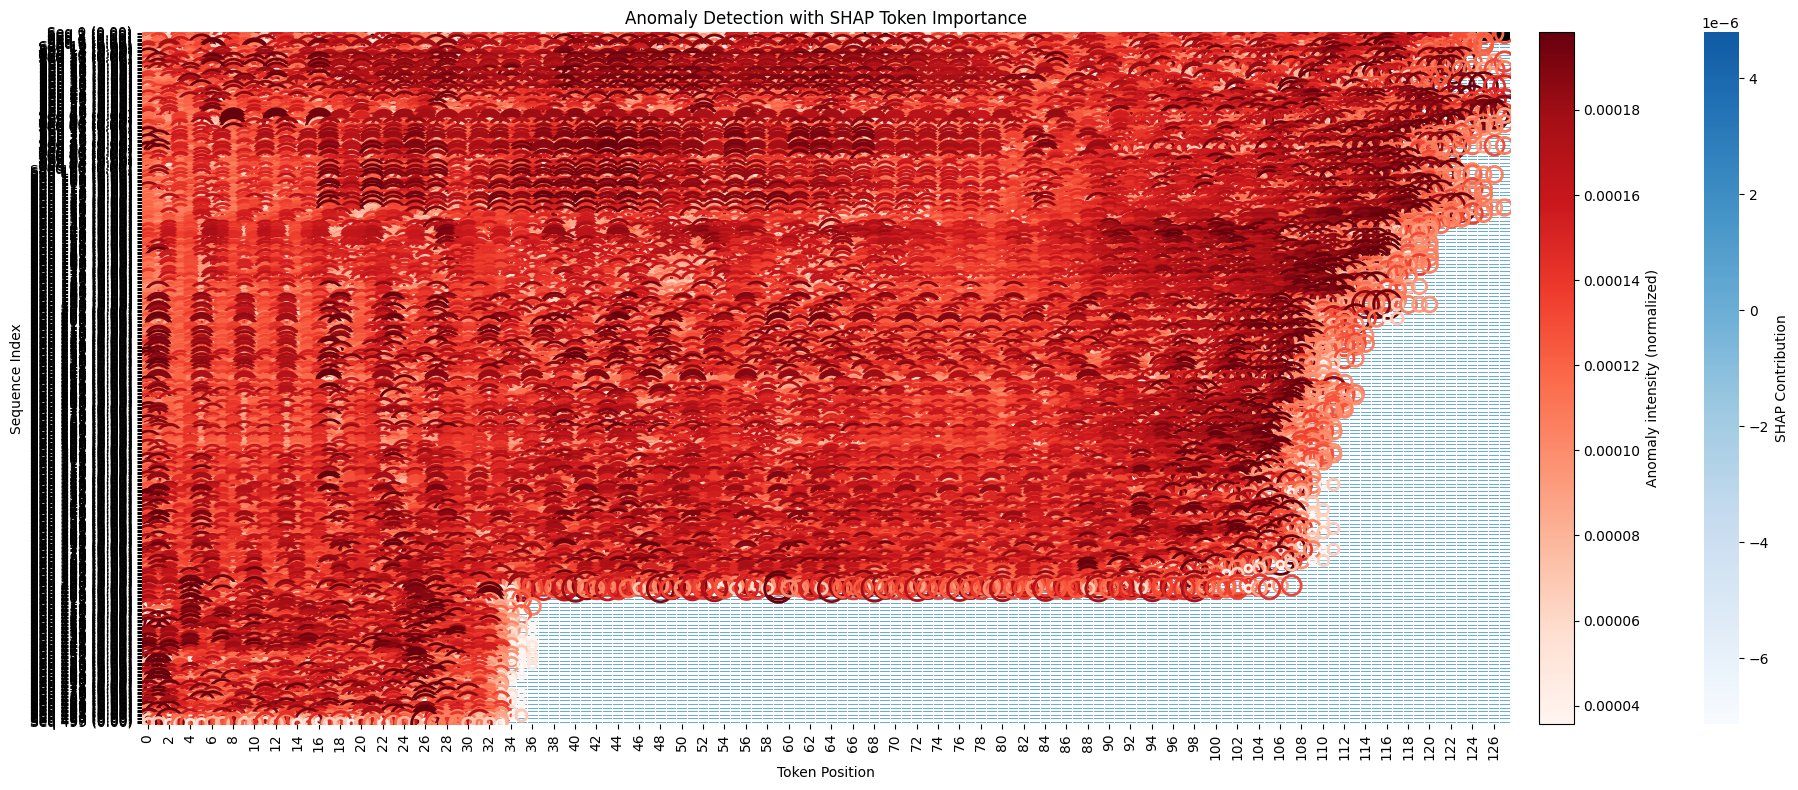

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from matplotlib.patches import Rectangle
import json
from tqdm import tqdm # Added import for tqdm

# -----------------------------
# 1️⃣ File paths
# -----------------------------
MODEL_PATH = "/content/01_model_final1.pt"
TOKENIZED_INPUTS = "/content/tokenized_inputs.npz"
LABEL_MAP_PATH = "/content/label_map.json"
PAD_ID = 0

# -----------------------------
# 2️⃣ Load label map
# -----------------------------
with open(LABEL_MAP_PATH, "r") as f:
    label_map = json.load(f)
print(f"Loaded label map with {len(label_map)} labels.")

# -----------------------------
# 3️⃣ Load tokenized inputs
# -----------------------------
data_np = np.load(TOKENIZED_INPUTS, allow_pickle=True)
features_np = data_np["tokenized_inputs"]  # shape: (num_sequences, seq_len)
num_sequences, seq_len = features_np.shape
print(f"Number of sequences: {num_sequences}, sequence length: {seq_len}")

# -----------------------------
# 4️⃣ Load model
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example model class (replace with your actual model definition)
class BERTLog(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        # Minimal placeholder
        self.embedding = torch.nn.Embedding(config["vocab_size"], config["hidden"])
        self.output = torch.nn.Linear(config["hidden"], len(label_map))
    def forward(self, x):
        x = self.embedding(x)
        x = x.mean(dim=1)
        return self.output(x)

# Example config
config = {
    "vocab_size": 74,
    "hidden": 66
}

model = BERTLog(config).to(device)
checkpoint = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(checkpoint, strict=False)
model.eval()
print(f"Model loaded successfully with {num_sequences} sequences.")

# -----------------------------
# 5️⃣ Use a subset for SHAP (memory safe)
# -----------------------------
import shap

subset_size = min(500, num_sequences)  # up to 3000 sequences
batch_size = 100  # batch size for SHAP to avoid memory crash

norm_shap_seq = []
heatmap_matrix = []
anomaly_scores = []

# Wrap model for SHAP (returns probabilities)
def model_wrapper(x):
    with torch.no_grad():
        x_tensor = torch.tensor(x, dtype=torch.long, device=device)
        out = model(x_tensor)
        return torch.softmax(out, dim=-1).cpu().numpy()

# Process in batches
for start in tqdm(range(0, subset_size, batch_size), desc="Computing SHAP in batches"):
    end = min(start + batch_size, subset_size)
    batch_features = features_np[start:end]
    batch_features_tensor = torch.tensor(batch_features, dtype=torch.long, device=device)

    # Background for SHAP
    background = batch_features_tensor[:50].cpu().numpy()
    explainer = shap.Explainer(model_wrapper, background)

    shap_values_batch = explainer(batch_features_tensor.cpu().numpy()).values

    for i in range(end - start):
        seq_ids = batch_features[i]
        mask_real = seq_ids != PAD_ID
        pred_class = np.argmax(model_wrapper(seq_ids[np.newaxis, :]), axis=1)[0]
        shap_vals = shap_values_batch[i, :, pred_class]
        heatmap_matrix.append(shap_vals[mask_real])

        # Normalize per sequence
        real_vals = shap_vals[mask_real]
        if np.any(real_vals):
            norm_vals = (real_vals - real_vals.min()) / (real_vals.max() - real_vals.min() + 1e-8)
        else:
            norm_vals = real_vals
        norm_shap_seq.append(norm_vals)

        # Compute anomaly score
        anomaly_scores.append(np.sum(np.abs(shap_vals)))

# Convert lists to arrays
max_len_seq = max(len(seq) for seq in heatmap_matrix)
heatmap_matrix_padded = np.array([np.pad(seq, (0, max_len_seq - len(seq)), 'constant')
                                  for seq in heatmap_matrix])
heatmap_matrix = heatmap_matrix_padded
norm_shap_seq_padded = np.array([np.pad(seq, (0, max_len_seq - len(seq)), 'constant')
                                 for seq in norm_shap_seq])
norm_shap_seq = norm_shap_seq_padded

anomaly_scores = np.array(anomaly_scores)
norm_scores = (anomaly_scores - anomaly_scores.min()) / (anomaly_scores.max() - anomaly_scores.min() + 1e-8)

# -----------------------------
# 6️⃣ Sort sequences by anomaly score
# -----------------------------
sorted_indices = np.argsort(anomaly_scores)[::-1]
heatmap_matrix_sorted = heatmap_matrix[sorted_indices]
norm_shap_sorted = norm_shap_seq[sorted_indices]
anomaly_scores_sorted = anomaly_scores[sorted_indices]
norm_scores_sorted = norm_scores[sorted_indices]

# -----------------------------
# 7️⃣ Plot heatmap (same as before)
# -----------------------------
fig, ax0 = plt.subplots(figsize=(20, 8))
sns.heatmap(
    heatmap_matrix_sorted,
    cmap="Blues",
    center=0,
    linewidths=0.5,
    cbar_kws={'label': 'SHAP Contribution'},
    ax=ax0
)

# Add red circles
min_marker, max_marker = 5, 20
num_sequences, seq_len = heatmap_matrix_sorted.shape
from matplotlib import cm
from matplotlib.patches import Rectangle

for i in range(num_sequences):
    for j in range(seq_len):
        if heatmap_matrix_sorted[i, j] != 0:
            color_intensity = norm_shap_sorted[i, j]
            size = min_marker + color_intensity * (max_marker - min_marker)
            ax0.plot(j + 0.5, i + 0.5, marker='o', markersize=size,
                     markerfacecolor='none',
                     markeredgecolor=cm.Reds(color_intensity),
                     markeredgewidth=2)

# Rightmost anomaly column
red_column = norm_scores_sorted[:, np.newaxis]
ax0.imshow(red_column, cmap='Reds', aspect='auto', extent=[seq_len, seq_len+1, 0, num_sequences])

# Y-axis labels
seq_labels = [f"Seq {i} ({anomaly_scores_sorted[i]:.2f})" for i in range(num_sequences)]
ax0.set_yticks(np.arange(num_sequences) + 0.5)
ax0.set_yticklabels(seq_labels, fontsize=10)

ax0.set_xlabel("Token Position")
ax0.set_ylabel("Sequence Index")
ax0.set_title("Anomaly Detection with SHAP Token Importance")

# Highlight top 5 sequences
top_n = min(5, num_sequences)
for i in range(top_n):
    ax0.add_patch(Rectangle(
        (0, i), seq_len+1, 1, fill=False, edgecolor='black', linewidth=2
    ))

# Colorbar
sm = cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=anomaly_scores.min(), vmax=anomaly_scores.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax0, fraction=0.05, pad=0.02)
cbar.set_label("Anomaly intensity (normalized)")

plt.tight_layout()
plt.show()

In [ ]:
#np.save("/content/heatmap_matrix.npy", heatmap_matrix)


Loaded sequences: 181
Plotting sorted ranks 20-22, first 15 tokens.
⚠️ Some rows are SPARSE (no full shap_values in JSONL). Heatmap will be sparse for those sequences.


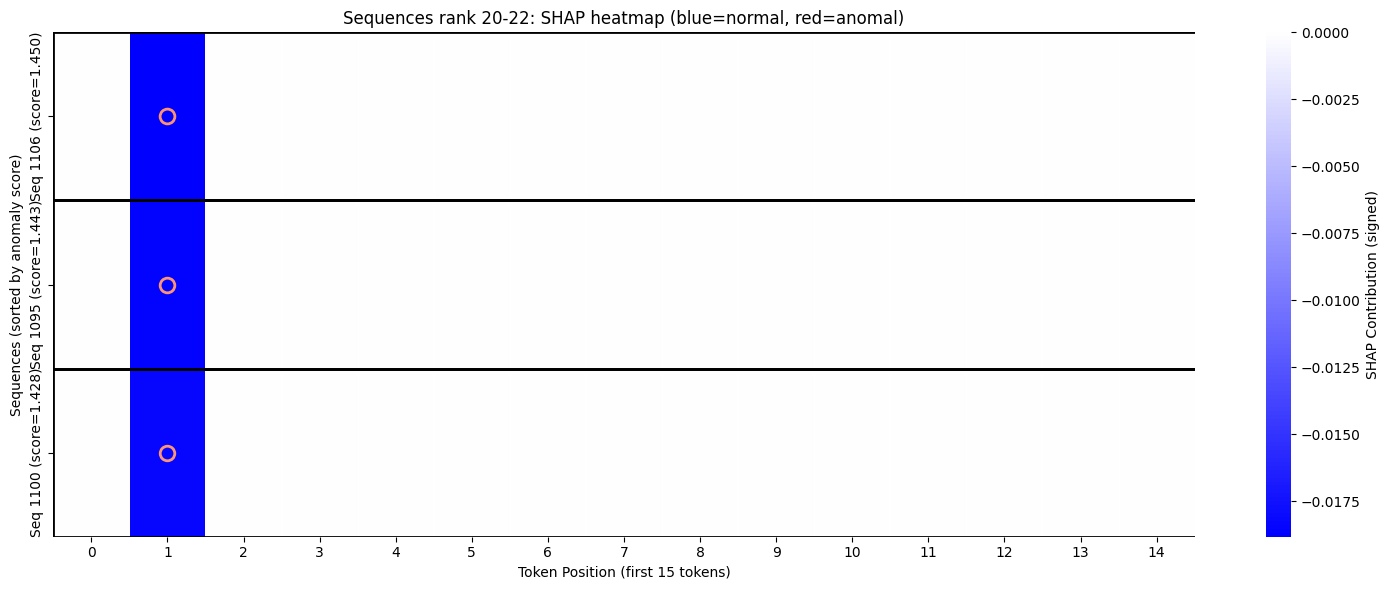


Logs for plotted sequences:

Rank 20 | sequence_id=1106 | score=1.4500
TIMESTAMP IP IP 11509 28776 UDP 112 Data FTP Laboriosam neque dicta in rerum. Magnam esse porro. Aut quam ea hic omnis repellat 
Rank 21 | sequence_id=1095 | score=1.4434
TIMESTAMP IP IP 25120 15747 TCP 822 Data HTTP Esse sapiente vel dolorum minima. Libero earum officia. Error doloribus rerum rati
Rank 22 | sequence_id=1100 | score=1.4285
TIMESTAMP IP IP 3185 44938 UDP 197 Control DNS Minus amet debitis reprehenderit. Id neque nulla et voluptas temporibus nihil inc


In [ ]:
# ============================================================
# HEATMAP VISUAL (your approach) from /content/shap_explanations_new.jsonl
# Red shade = more anomalous contribution (SHAP > 0)
# Blue shade = more normal contribution (SHAP < 0)
#
# IMPORTANT:
# - If your JSONL has full "shap_values" (len=128), this will be a true heatmap.
# - If not, it will be sparse (only top_char_tokens positions colored).
# ============================================================

!pip -q install -U seaborn

import json, random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from matplotlib.patches import Rectangle

JSONL_PATH = "/content/shap_explanations_new.jsonl"
MAX_LEN = 128

# -----------------------------
# 1) Load JSONL
# -----------------------------
recs = []
with open(JSONL_PATH, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if line:
            recs.append(json.loads(line))

num_sequences = len(recs)
print("Loaded sequences:", num_sequences)

# -----------------------------
# 2) Build full-length SHAP vectors + anomaly scores
# -----------------------------
def build_shap_vec(rec, max_len=128):
    # Preferred: full vector
    if "shap_values" in rec and rec["shap_values"] is not None:
        v = np.asarray(rec["shap_values"], dtype=float).reshape(-1)
        if len(v) < max_len:
            v = np.pad(v, (0, max_len-len(v)), constant_values=0.0)
        return v[:max_len], True

    # Fallback: sparse from top_char_tokens
    v = np.zeros(max_len, dtype=float)
    for c in rec.get("top_char_tokens", []):
        p = int(c.get("pos", -1))
        if 0 <= p < max_len:
            v[p] = float(c.get("shap", 0.0))
    return v, False

heatmap_matrix = []
full_flags = []
scores = []

for r in recs:
    v, is_full = build_shap_vec(r, MAX_LEN)
    heatmap_matrix.append(v)
    full_flags.append(is_full)
    scores.append(float(r.get("score", 0.0)))

heatmap_matrix = np.asarray(heatmap_matrix)   # (N, 128)
scores = np.asarray(scores)

# Sort by anomaly score (higher = more anomalous)
sorted_indices = np.argsort(scores)[::-1]
heatmap_matrix_sorted = heatmap_matrix[sorted_indices]
scores_sorted = scores[sorted_indices]
full_flags_sorted = np.asarray(full_flags)[sorted_indices]

# Normalize for rightmost red column
norm_scores = (scores_sorted - scores_sorted.min()) / (scores_sorted.max() - scores_sorted.min() + 1e-8)

# Normalize |shap| for circle sizing
abs_shap = np.abs(heatmap_matrix_sorted)
abs_shap_max = abs_shap.max() + 1e-9
norm_shap_sorted = abs_shap / abs_shap_max

# -----------------------------
# 3) Choose which sequences to plot + first K tokens
#     (like your example: sequences 20-22 after sorting)
# -----------------------------
TOP_START = 20
TOP_END   = 23     # 20,21,22
K_TOKENS  = 15

plot_indices = np.arange(TOP_START, min(TOP_END, num_sequences))
heatmap_plot = heatmap_matrix_sorted[plot_indices, :K_TOKENS]
norm_shap_plot = norm_shap_sorted[plot_indices, :K_TOKENS]
norm_scores_plot = norm_scores[plot_indices]
scores_plot = scores_sorted[plot_indices]

num_plot_seq, seq_len_plot = heatmap_plot.shape

print(f"Plotting sorted ranks {TOP_START}-{TOP_END-1}, first {K_TOKENS} tokens.")
if not np.all(full_flags_sorted[plot_indices]):
    print("⚠️ Some rows are SPARSE (no full shap_values in JSONL). Heatmap will be sparse for those sequences.")

# -----------------------------
# 4) Plot heatmap (blue=normal, red=anomal)
# -----------------------------
fig, ax0 = plt.subplots(figsize=(15, 6))

# Center at 0 so negatives = blue, positives = red
sns.heatmap(
    heatmap_plot,
    cmap="bwr",        # blue-white-red
    center=0,
    linewidths=0.5,
    cbar_kws={'label': 'SHAP Contribution (signed)'},
    ax=ax0
)

# Add circles for importance (by |SHAP|)
min_marker, max_marker = 5, 20
for i in range(num_plot_seq):
    for j in range(seq_len_plot):
        v = heatmap_plot[i, j]
        if v != 0:
            intensity = norm_shap_plot[i, j]  # 0..1
            size = min_marker + intensity * (max_marker - min_marker)
            # circle color stronger for bigger |shap|
            ax0.plot(j + 0.5, i + 0.5, marker='o', markersize=size,
                     markerfacecolor='none',
                     markeredgecolor=cm.Reds(intensity),
                     markeredgewidth=2)

# Rightmost anomaly column (normalized NLL score)
red_column = norm_scores_plot[:, np.newaxis]
ax0.imshow(red_column, cmap='Reds', aspect='auto',
           extent=[seq_len_plot, seq_len_plot+1, 0, num_plot_seq])

# Y labels: show real sequence_id + score
seq_labels = []
for row_i, global_sorted_idx in enumerate(sorted_indices[plot_indices]):
    sid = recs[global_sorted_idx].get("sequence_id", f"idx{global_sorted_idx}")
    seq_labels.append(f"Seq {sid} (score={scores_plot[row_i]:.3f})")

ax0.set_yticks(np.arange(num_plot_seq) + 0.5)
ax0.set_yticklabels(seq_labels, fontsize=10)

ax0.set_xlabel(f"Token Position (first {K_TOKENS} tokens)")
ax0.set_ylabel("Sequences (sorted by anomaly score)")
ax0.set_title(f"Sequences rank {TOP_START}-{TOP_END-1}: SHAP heatmap (blue=normal, red=anomal)")

# Outline each plotted sequence row
for i in range(num_plot_seq):
    ax0.add_patch(Rectangle((0, i), seq_len_plot+1, 1, fill=False, edgecolor='black', linewidth=2))

plt.tight_layout()
plt.show()

# -----------------------------
# 5) Print logs for those plotted sequences
# -----------------------------
print("\nLogs for plotted sequences:\n")
for row_i, global_sorted_idx in enumerate(sorted_indices[plot_indices]):
    r = recs[global_sorted_idx]
    print("="*90)
    print(f"Rank {plot_indices[row_i]} | sequence_id={r.get('sequence_id')} | score={float(r.get('score',0.0)):.4f}")
    print((r.get("reconstructed_preview","") or "").replace("\\n","\n"))


In [ ]:
# ============================================================
# WHOLE CORRECT CODE (runs without your SHAP errors)
# LogBERT MLM (output B,128,74) + REAL SHAP -> JSONL
#
# INPUTS:
#   /content/01_model_final1.pt
#   /content/config.json
#   /content/tokenizer.json
#   /content/new.json
#
# OUTPUT:
#   /content/shap_explanations_new.jsonl
#
# Works on CPU/GPU. Memory efficient: streams + batches + writes JSONL.
# ============================================================

!pip -q install -U shap tqdm

import os, json, re
import numpy as np
import torch
import shap
from tqdm import tqdm

# -----------------------------
# Paths
# -----------------------------
MODEL_PATH    = "/content/01_model_final1.pt"
CONFIG_PATH   = "/content/config.json"
VOCAB_PATH    = "/content/tokenizer.json"
NEW_JSON_PATH = "/content/new.json"
OUT_JSONL     = "/content/shap_explanations_new.jsonl"

PAD_TOKEN = "<PAD>"
UNK_TOKEN = "<UNK>"

# -----------------------------
# Device
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -----------------------------
# Load config
# -----------------------------
with open(CONFIG_PATH, "r", encoding="utf-8") as f:
    config = json.load(f)

MAX_LEN    = int(config["max_len"])     # should be 128
VOCAB_SIZE = int(config["vocab_size"])  # should be 74

# -----------------------------
# Load vocab (char-level token->id dict)
# -----------------------------
with open(VOCAB_PATH, "r", encoding="utf-8") as f:
    token2id = json.load(f)

id2token = {int(v): k for k, v in token2id.items()}
PAD_ID = int(token2id.get(PAD_TOKEN, 0))
UNK_ID = int(token2id.get(UNK_TOKEN, 1))

print("Vocab size:", len(token2id), "| PAD_ID:", PAD_ID, "| UNK_ID:", UNK_ID)

# -----------------------------
# Build model (your repo style): BERT -> BERTLog(bert, vocab_size)
# -----------------------------
from bert_pytorch.model.bert import BERT
from bert_pytorch.model.log_model import BERTLog

# MUST match training
IS_LOGKEY = True
IS_TIME   = False

bert = BERT(
    vocab_size=config["vocab_size"],
    max_len=config["max_len"],
    hidden=config["hidden"],
    n_layers=config["n_layers"],
    attn_heads=config["attn_heads"],
    dropout=config["dropout"],
    is_logkey=IS_LOGKEY,
    is_time=IS_TIME,
).to(device)

model = BERTLog(bert=bert, vocab_size=config["vocab_size"]).to(device)

ckpt = torch.load(MODEL_PATH, map_location=device)
if isinstance(ckpt, dict) and any(k in ckpt for k in ["state_dict", "model_state_dict"]):
    ckpt = ckpt.get("state_dict", ckpt.get("model_state_dict"))

model.load_state_dict(ckpt, strict=True)
model.eval()
print("✅ Loaded trained LogBERT checkpoint with strict=True")

# -----------------------------
# Stream /content/new.json (JSONL or JSON array)
# -----------------------------
LOG_KEYS = ["raw_logs", "logs", "log", "text", "message", "content"]
ID_KEYS  = ["sequence_id", "sequenceId", "seq_id", "seqId", "id", "Sequence ID"]

def stringify_logs(x):
    if x is None: return ""
    if isinstance(x, str): return x
    if isinstance(x, list): return "\n".join(str(i) for i in x)
    return str(x)

def stream_entries(path):
    with open(path, "r", encoding="utf-8") as f:
        first = f.read(1)
        f.seek(0)
        if first == "[":
            arr = json.load(f)  # JSON array must be loaded once
            for i, e in enumerate(arr):
                yield i, e
        else:
            idx = 0
            for line in f:
                line = line.strip().rstrip(",")
                if not line:
                    continue
                if line.startswith("{"):
                    yield idx, json.loads(line)
                    idx += 1

def extract_log_and_id(entry, fallback_idx):
    if not isinstance(entry, dict):
        return str(entry), str(fallback_idx)

    sid = None
    for k in ID_KEYS:
        if k in entry and entry[k] is not None:
            sid = entry[k]
            break
    sid = str(sid) if sid is not None else str(fallback_idx)

    logv = ""
    for k in LOG_KEYS:
        if k in entry and entry[k] is not None:
            logv = entry[k]
            break
    return stringify_logs(logv), sid

# -----------------------------
# Char-level tokenization (max_len padding/truncation)
# -----------------------------
def encode_char_level(text: str) -> np.ndarray:
    ids = [int(token2id.get(ch, UNK_ID)) for ch in text]
    ids = ids[:MAX_LEN]
    if len(ids) < MAX_LEN:
        ids += [PAD_ID] * (MAX_LEN - len(ids))
    return np.asarray(ids, dtype=np.int64)

# -----------------------------
# Robust forward: model returns dict -> pick tensor
# -----------------------------
@torch.no_grad()
def model_forward_any(x_tensor: torch.Tensor):
    try:
        return model(x_tensor)
    except TypeError:
        return model(x_tensor, time_info=None)

def pick_tensor(out):
    if isinstance(out, dict):
        for k in ["logkey_output", "masked_lm", "mask_lm", "logits", "output"]:
            if k in out and torch.is_tensor(out[k]):
                return out[k]
        for v in out.values():
            if torch.is_tensor(v):
                return v
        raise TypeError(f"dict output had no tensors. keys={list(out.keys())}")
    if isinstance(out, (tuple, list)):
        for v in out:
            if torch.is_tensor(v):
                return v
        raise TypeError("tuple/list output had no tensors")
    if torch.is_tensor(out):
        return out
    raise TypeError(f"Unexpected output type: {type(out)}")

# -----------------------------
# Target score for MLM: mean token NLL (higher = more anomalous)
# -----------------------------
@torch.no_grad()
def nll_score(x_np: np.ndarray) -> np.ndarray:
    x = torch.tensor(x_np, dtype=torch.long, device=device)        # (B, L)
    out = model_forward_any(x)
    logits = pick_tensor(out)                                      # (B, L, V)

    # Ensure MLM shape
    if logits.dim() != 3 or logits.size(-1) != VOCAB_SIZE:
        raise ValueError(f"Expected MLM logits (B,L,V={VOCAB_SIZE}), got {tuple(logits.shape)}")

    logp = torch.log_softmax(logits, dim=-1)                       # (B, L, V)
    y = x.clamp(0, VOCAB_SIZE - 1)                                 # (B, L)

    nll = -logp.gather(2, y.unsqueeze(-1)).squeeze(-1)             # (B, L)

    mask = (y != PAD_ID).float()
    score = (nll * mask).sum(dim=1) / mask.sum(dim=1).clamp_min(1.0)
    return score.detach().cpu().numpy()                             # (B,)

def shap_model(x_np: np.ndarray) -> np.ndarray:
    return nll_score(x_np).reshape(-1, 1)

# -----------------------------
# SHAP background (CPU-friendly)
# -----------------------------
BACKGROUND_N = 20   # smaller = faster
cache_first = []
background_rows = []

for idx, entry in stream_entries(NEW_JSON_PATH):
    txt, sid = extract_log_and_id(entry, idx)
    cache_first.append((txt, sid))
    background_rows.append(encode_char_level(txt))
    if len(background_rows) >= BACKGROUND_N:
        break

background = np.stack(background_rows, axis=0)

explainer = shap.Explainer(shap_model, background, algorithm="permutation")
print("✅ SHAP explainer ready. Background:", background.shape)

# Permutation explainer needs >= 2*features+1 evaluations
MIN_EVALS = 2 * MAX_LEN + 1
NSAMPLES  = MIN_EVALS          # you can increase above MIN_EVALS for better accuracy
BATCH_SIZE = 4                 # CPU: 2-4, GPU: 8-16

print("PermutationExplainer MIN_EVALS:", MIN_EVALS, "| Using max_evals:", NSAMPLES)

# -----------------------------
# Helpers to convert SHAP output shape safely
# -----------------------------
def shap_values_to_2d(values):
    arr = np.array(values)
    if arr.ndim == 3 and arr.shape[-1] == 1:
        return arr[:, :, 0]
    if arr.ndim == 2:
        return arr
    raise ValueError(f"Unexpected SHAP values shape: {arr.shape}")

# -----------------------------
# Decode + extract top tokens
# -----------------------------
WORD_RE = re.compile(r"[A-Za-z0-9_]+")

def decode_chars(seq_ids_arr: np.ndarray) -> str:
    return "".join(id2token.get(int(t), UNK_TOKEN) for t in seq_ids_arr if int(t) != PAD_ID)

def top_word_tokens(seq_ids_arr: np.ndarray, shap_row: np.ndarray, k=10):
    text = decode_chars(seq_ids_arr)
    char_vals = shap_row[seq_ids_arr != PAD_ID]
    abs_vals = np.abs(char_vals)

    tokens = []
    for m in WORD_RE.finditer(text):
        s, e = m.start(), m.end()
        tokens.append({
            "token": text[s:e],
            "sum_abs_shap": float(abs_vals[s:e].sum()),
            "char_start": int(s),
            "char_end": int(e),
        })
    tokens.sort(key=lambda x: x["sum_abs_shap"], reverse=True)
    return tokens[:k], text

def top_char_tokens(seq_ids_arr: np.ndarray, shap_row: np.ndarray, k=10):
    mask = seq_ids_arr != PAD_ID
    pos = np.where(mask)[0]
    vals = shap_row[mask]
    order = np.argsort(np.abs(vals))[::-1][:k]
    return [{
        "pos": int(pos[i]),
        "token_id": int(seq_ids_arr[pos[i]]),
        "token": id2token.get(int(seq_ids_arr[pos[i]]), UNK_TOKEN),
        "shap": float(vals[i])  # signed
    } for i in order]

# -----------------------------
# Write JSONL incrementally (memory efficient)
# -----------------------------
if os.path.exists(OUT_JSONL):
    os.remove(OUT_JSONL)

def process_batch(texts, ids):
    Xb = np.stack([encode_char_level(t) for t in texts], axis=0)
    scores = nll_score(Xb)  # higher = more anomalous

    sv = explainer(Xb, max_evals=NSAMPLES).values
    sv = shap_values_to_2d(sv)  # (B, L)

    recs = []
    for i in range(len(texts)):
        words, recon = top_word_tokens(Xb[i], sv[i], k=10)
        chars = top_char_tokens(Xb[i], sv[i], k=10)
        recs.append({
            "sequence_id": ids[i],
            "mode": "mlm_nll",
            "score": float(scores[i]),
            "reconstructed_preview": recon[:300].replace("\n", "\\n"),
            "top_word_tokens": words,
            "top_char_tokens": chars
        })
    return recs

pending_texts, pending_ids = [], []

# include cached entries in output too
for txt, sid in cache_first:
    pending_texts.append(txt)
    pending_ids.append(sid)

cached_len = len(cache_first)

with open(OUT_JSONL, "w", encoding="utf-8") as fout:
    for idx, entry in tqdm(stream_entries(NEW_JSON_PATH), desc="SHAP over new.json"):
        if idx < cached_len:
            continue
        txt, sid = extract_log_and_id(entry, idx)
        pending_texts.append(txt)
        pending_ids.append(sid)

        if len(pending_texts) >= BATCH_SIZE:
            recs = process_batch(pending_texts, pending_ids)
            for r in recs:
                fout.write(json.dumps(r, ensure_ascii=False) + "\n")
            pending_texts, pending_ids = [], []

    if pending_texts:
        recs = process_batch(pending_texts, pending_ids)
        for r in recs:
            fout.write(json.dumps(r, ensure_ascii=False) + "\n")

print("✅ Saved SHAP explanations to:", OUT_JSONL)


Using device: cpu
Vocab size: 74 | PAD_ID: 0 | UNK_ID: 1
✅ Loaded trained LogBERT checkpoint with strict=True
✅ SHAP explainer ready. Background: (20, 128)
PermutationExplainer MIN_EVALS: 257 | Using max_evals: 257


SHAP over new.json: 0it [00:00, ?it/s]
PermutationExplainer explainer: 100%|██████████| 21/21 [24:16<00:00, 72.77s/it]
PermutationExplainer explainer: 22it [25:32, 72.98s/it]
SHAP over new.json: 21it [25:32, 72.99s/it]
PermutationExplainer explainer: 100%|██████████| 4/4 [03:30<00:00, 56.87s/it]
PermutationExplainer explainer: 5it [04:50, 72.71s/it]
SHAP over new.json: 25it [30:23, 72.93s/it]
PermutationExplainer explainer: 100%|██████████| 4/4 [03:22<00:00, 54.35s/it]
PermutationExplainer explainer: 5it [04:40, 70.06s/it]
SHAP over new.json: 29it [35:04, 72.27s/it]
PermutationExplainer explainer: 100%|██████████| 4/4 [03:18<00:00, 53.08s/it]
PermutationExplainer explainer: 5it [04:32, 68.05s/it]
SHAP over new.json: 33it [39:36, 71.21s/it]
PermutationExplainer explainer: 100%|██████████| 4/4 [03:19<00:00, 52.73s/it]
PermutationExplainer explainer: 5it [04:33, 68.28s/it]
SHAP over new.json: 37it [44:09, 70.44s/it]
PermutationExplainer explainer: 100%|██████████| 4/4 [03:25<00:00, 55.20s

✅ Saved SHAP explanations to: /content/shap_explanations_new.jsonl


In [ ]:
# ============================================================
# WHOLE CORRECTED CODE (dense per-token SHAP % + JSONL for LLM)
# LogBERT MLM (output B,128,74) + REAL SHAP (Permutation) -> JSONL
#
# INPUTS (you already have):
#   /content/01_model_final1.pt
#   /content/config.json
#   /content/tokenizer.json
#   /content/new.json   (JSONL or JSON array)
#
# OUTPUT (LLM-ready, token-wise %):
#   /content/shap_tokenwise_new.jsonl
#
# What the output contains per sequence:
#   - reconstructed_preview (readable log preview)
#   - score (mlm_nll anomaly score)
#   - tokens (length 128, char-level token at each position)
#   - shap_values (length 128, signed SHAP per position)
#   - token_pct (length 128, |SHAP|% per position, sums ~100 over non-PAD)
#   - top_char_tokens (top-k positions with signed SHAP)
#   - top_word_tokens (word-like spans with summed |SHAP|)
#
# Notes:
#   - "token_pct" is your “each token anomal %”.
#   - SHAP Permutation is expensive. Reduce SUBSET_N / NSAMPLES for speed.
# ============================================================

!pip -q install -U shap tqdm

import os, json, re
import numpy as np
import torch
import shap
from tqdm import tqdm

# -----------------------------
# Paths
# -----------------------------
MODEL_PATH    = "/content/01_model_final1.pt"
CONFIG_PATH   = "/content/config.json"
VOCAB_PATH    = "/content/tokenizer.json"
NEW_JSON_PATH = "/content/new.json"
OUT_JSONL     = "/content/shap_tokenwise_new.jsonl"

PAD_TOKEN = "<PAD>"
UNK_TOKEN = "<UNK>"

# -----------------------------
# Device
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -----------------------------
# Load config
# -----------------------------
with open(CONFIG_PATH, "r", encoding="utf-8") as f:
    config = json.load(f)

MAX_LEN    = int(config["max_len"])     # 128
VOCAB_SIZE = int(config["vocab_size"])  # 74

# -----------------------------
# Load vocab (char-level token->id dict)
# -----------------------------
with open(VOCAB_PATH, "r", encoding="utf-8") as f:
    token2id = json.load(f)

id2token = {int(v): k for k, v in token2id.items()}
PAD_ID = int(token2id.get(PAD_TOKEN, 0))
UNK_ID = int(token2id.get(UNK_TOKEN, 1))

print("Vocab size:", len(token2id), "| PAD_ID:", PAD_ID, "| UNK_ID:", UNK_ID)

# -----------------------------
# Build model (MUST match training): BERT -> BERTLog(bert, vocab_size)
# -----------------------------
from bert_pytorch.model.bert import BERT
from bert_pytorch.model.log_model import BERTLog

bert = BERT(
    vocab_size=config["vocab_size"],
    max_len=config["max_len"],
    hidden=config["hidden"],
    n_layers=config["n_layers"],
    attn_heads=config["attn_heads"],
    dropout=config["dropout"],
    is_logkey=True,
    is_time=False,
).to(device)

model = BERTLog(bert=bert, vocab_size=config["vocab_size"]).to(device)

ckpt = torch.load(MODEL_PATH, map_location=device)
if isinstance(ckpt, dict) and any(k in ckpt for k in ["state_dict", "model_state_dict"]):
    ckpt = ckpt.get("state_dict", ckpt.get("model_state_dict"))

model.load_state_dict(ckpt, strict=True)
model.eval()
print("✅ Loaded trained LogBERT checkpoint with strict=True")

# -----------------------------
# Stream /content/new.json (JSONL or JSON array)
# -----------------------------
LOG_KEYS = ["raw_logs", "logs", "log", "text", "message", "content"]
ID_KEYS  = ["sequence_id", "sequenceId", "seq_id", "seqId", "id", "Sequence ID"]

def stringify_logs(x):
    if x is None: return ""
    if isinstance(x, str): return x
    if isinstance(x, list): return "\n".join(str(i) for i in x)
    return str(x)

def stream_entries(path):
    with open(path, "r", encoding="utf-8") as f:
        first = f.read(1)
        f.seek(0)
        if first == "[":
            arr = json.load(f)  # JSON array must be loaded once
            for i, e in enumerate(arr):
                yield i, e
        else:
            idx = 0
            for line in f:
                line = line.strip().rstrip(",")
                if not line:
                    continue
                if line.startswith("{"):
                    yield idx, json.loads(line)
                    idx += 1

def extract_log_and_id(entry, fallback_idx):
    if not isinstance(entry, dict):
        return str(entry), str(fallback_idx)

    sid = None
    for k in ID_KEYS:
        if k in entry and entry[k] is not None:
            sid = entry[k]
            break
    sid = str(sid) if sid is not None else str(fallback_idx)

    logv = ""
    for k in LOG_KEYS:
        if k in entry and entry[k] is not None:
            logv = entry[k]
            break
    return stringify_logs(logv), sid

# -----------------------------
# Char-level tokenization (max_len padding/truncation)
# -----------------------------
def encode_char_level(text: str) -> np.ndarray:
    ids = [int(token2id.get(ch, UNK_ID)) for ch in text]
    ids = ids[:MAX_LEN]
    if len(ids) < MAX_LEN:
        ids += [PAD_ID] * (MAX_LEN - len(ids))
    return np.asarray(ids, dtype=np.int64)

# -----------------------------
# Robust forward: model may return dict -> pick tensor
# -----------------------------
@torch.no_grad()
def model_forward_any(x_tensor: torch.Tensor):
    try:
        return model(x_tensor)
    except TypeError:
        return model(x_tensor, time_info=None)

def pick_tensor(out):
    if isinstance(out, dict):
        for k in ["logkey_output", "masked_lm", "mask_lm", "logits", "output"]:
            if k in out and torch.is_tensor(out[k]):
                return out[k]
        for v in out.values():
            if torch.is_tensor(v):
                return v
        raise TypeError(f"dict output had no tensors. keys={list(out.keys())}")
    if isinstance(out, (tuple, list)):
        for v in out:
            if torch.is_tensor(v):
                return v
        raise TypeError("tuple/list output had no tensors")
    if torch.is_tensor(out):
        return out
    raise TypeError(f"Unexpected output type: {type(out)}")

# -----------------------------
# Target score for MLM: mean token NLL (higher = more anomalous)
# -----------------------------
@torch.no_grad()
def nll_score(x_np: np.ndarray) -> np.ndarray:
    x = torch.tensor(x_np, dtype=torch.long, device=device)        # (B, L)
    out = model_forward_any(x)
    logits = pick_tensor(out)                                      # (B, L, V)

    if logits.dim() != 3 or logits.size(-1) != VOCAB_SIZE:
        raise ValueError(f"Expected MLM logits (B,L,V={VOCAB_SIZE}), got {tuple(logits.shape)}")

    logp = torch.log_softmax(logits, dim=-1)                       # (B, L, V)
    y = x.clamp(0, VOCAB_SIZE - 1)                                 # (B, L)

    nll = -logp.gather(2, y.unsqueeze(-1)).squeeze(-1)             # (B, L)
    mask = (y != PAD_ID).float()

    score = (nll * mask).sum(dim=1) / mask.sum(dim=1).clamp_min(1.0)
    return score.detach().cpu().numpy()                             # (B,)

def shap_model(x_np: np.ndarray) -> np.ndarray:
    return nll_score(x_np).reshape(-1, 1)

# -----------------------------
# SHAP background (small for speed)
# -----------------------------
BACKGROUND_N = 20
background_rows = []
cache_first = []

for idx, entry in stream_entries(NEW_JSON_PATH):
    txt, sid = extract_log_and_id(entry, idx)
    cache_first.append((txt, sid))
    background_rows.append(encode_char_level(txt))
    if len(background_rows) >= BACKGROUND_N:
        break

background = np.stack(background_rows, axis=0)

# Choose explainer
explainer = shap.Explainer(shap_model, background, algorithm="permutation")
print("✅ SHAP explainer ready. Background:", background.shape)

# Permutation explainer needs >= 2*features+1 evaluations
MIN_EVALS = 2 * MAX_LEN + 1
NSAMPLES  = MIN_EVALS          # increase (e.g., 513, 1025) for better accuracy
BATCH_SIZE = 4 if device.type == "cpu" else 8  # GPU can handle larger

print("PermutationExplainer MIN_EVALS:", MIN_EVALS, "| Using max_evals:", NSAMPLES)
print("BATCH_SIZE:", BATCH_SIZE)

# -----------------------------
# Convert SHAP output to (B, L)
# -----------------------------
def shap_values_to_2d(values):
    arr = np.array(values)
    if arr.ndim == 3 and arr.shape[-1] == 1:
        return arr[:, :, 0]
    if arr.ndim == 2:
        return arr
    raise ValueError(f"Unexpected SHAP values shape: {arr.shape}")

# -----------------------------
# Decode + token aggregation
# -----------------------------
WORD_RE = re.compile(r"[A-Za-z0-9_]+")

def decode_chars(seq_ids_arr: np.ndarray) -> str:
    return "".join(id2token.get(int(t), UNK_TOKEN) for t in seq_ids_arr if int(t) != PAD_ID)

def top_word_tokens(seq_ids_arr: np.ndarray, shap_row: np.ndarray, k=10):
    text = decode_chars(seq_ids_arr)
    char_vals = shap_row[seq_ids_arr != PAD_ID]
    abs_vals = np.abs(char_vals)

    tokens = []
    for m in WORD_RE.finditer(text):
        s, e = m.start(), m.end()
        tokens.append({
            "token": text[s:e],
            "sum_abs_shap": float(abs_vals[s:e].sum()),
            "char_start": int(s),
            "char_end": int(e),
        })
    tokens.sort(key=lambda x: x["sum_abs_shap"], reverse=True)
    return tokens[:k], text

def top_char_tokens(seq_ids_arr: np.ndarray, shap_row: np.ndarray, k=15):
    mask = seq_ids_arr != PAD_ID
    pos = np.where(mask)[0]
    vals = shap_row[mask]
    order = np.argsort(np.abs(vals))[::-1][:k]
    out = []
    for idx in order:
        p = int(pos[idx])
        tid = int(seq_ids_arr[p])
        out.append({
            "pos": p,
            "token_id": tid,
            "token": id2token.get(tid, UNK_TOKEN),
            "shap": float(vals[idx])  # signed
        })
    return out

# -----------------------------
# Batch processing (dense token-wise %)
# -----------------------------
def process_batch(texts, ids):
    Xb = np.stack([encode_char_level(t) for t in texts], axis=0)   # (B, L)
    scores = nll_score(Xb)                                         # (B,)

    sv = explainer(Xb, max_evals=NSAMPLES).values
    sv = shap_values_to_2d(sv)                                     # (B, L)

    recs = []
    for i in range(len(texts)):
        seq_ids_arr = Xb[i]
        shap_row = sv[i]

        # tokens at each position (length 128)
        tokens = [id2token.get(int(t), UNK_TOKEN) for t in seq_ids_arr.tolist()]

        # token-wise % contribution (absolute shap, normalized over non-PAD)
        abs_all = np.abs(shap_row).copy()
        abs_all[seq_ids_arr == PAD_ID] = 0.0
        total = float(abs_all.sum()) + 1e-12
        token_pct = (abs_all / total * 100.0).tolist()  # length 128

        # summaries
        words, recon = top_word_tokens(seq_ids_arr, shap_row, k=10)
        chars = top_char_tokens(seq_ids_arr, shap_row, k=15)

        recs.append({
            "sequence_id": ids[i],
            "mode": "mlm_nll",
            "score": float(scores[i]),
            "reconstructed_preview": recon[:300].replace("\n", "\\n"),

            # ✅ LLM-ready dense data
            "tokens": tokens,                 # length 128
            "shap_values": shap_row.tolist(), # length 128 (signed)
            "token_pct": token_pct,           # length 128 (|SHAP|%, sums ~100 over non-PAD)

            # optional summaries
            "top_word_tokens": words,
            "top_char_tokens": chars,
        })

    return recs

# -----------------------------
# Main loop: stream + write JSONL
# -----------------------------
if os.path.exists(OUT_JSONL):
    os.remove(OUT_JSONL)

pending_texts, pending_ids = [], []

# include cached entries in output too
for txt, sid in cache_first:
    pending_texts.append(txt)
    pending_ids.append(sid)

cached_len = len(cache_first)

with open(OUT_JSONL, "w", encoding="utf-8") as fout:
    for idx, entry in tqdm(stream_entries(NEW_JSON_PATH), desc="SHAP over new.json"):
        if idx < cached_len:
            continue

        txt, sid = extract_log_and_id(entry, idx)
        pending_texts.append(txt)
        pending_ids.append(sid)

        if len(pending_texts) >= BATCH_SIZE:
            recs = process_batch(pending_texts, pending_ids)
            for r in recs:
                fout.write(json.dumps(r, ensure_ascii=False) + "\n")
            pending_texts, pending_ids = [], []

    if pending_texts:
        recs = process_batch(pending_texts, pending_ids)
        for r in recs:
            fout.write(json.dumps(r, ensure_ascii=False) + "\n")

print("✅ Saved token-wise SHAP JSONL to:", OUT_JSONL)
print("   Each row has: tokens[128], shap_values[128], token_pct[128] (LLM-ready)")


Using device: cuda
Vocab size: 74 | PAD_ID: 0 | UNK_ID: 1
✅ Loaded trained LogBERT checkpoint with strict=True
✅ SHAP explainer ready. Background: (20, 128)
PermutationExplainer MIN_EVALS: 257 | Using max_evals: 257
BATCH_SIZE: 8


SHAP over new.json: 0it [00:00, ?it/s]
PermutationExplainer explainer: 100%|██████████| 21/21 [00:26<00:00,  1.01it/s]
PermutationExplainer explainer: 22it [00:27,  1.53s/it]
SHAP over new.json: 181it [03:16,  1.09s/it]

✅ Saved token-wise SHAP JSONL to: /content/shap_tokenwise_new.jsonl
   Each row has: tokens[128], shap_values[128], token_pct[128] (LLM-ready)
